_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c2_interpolated_1550_100.csv")
training_set = data.iloc[:, 1]
training_set

0       90.500000
1       90.275910
2       90.051821
3       89.827731
4       89.603641
          ...    
1645    67.357190
1646    67.347852
1647    67.338515
1648    67.329178
1649    67.319841
Name: C2, Length: 1650, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(1550)
training_set

0       90.500000
1       90.275910
2       90.051821
3       89.827731
4       89.603641
          ...    
1545     0.525366
1546     0.064448
1547     0.292134
1548     0.000000
1549     0.000000
Name: C2, Length: 1550, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,90.500000,0.000298
1,90.275910,0.000298
2,90.051821,0.000297
3,89.827731,0.000297
4,89.603641,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

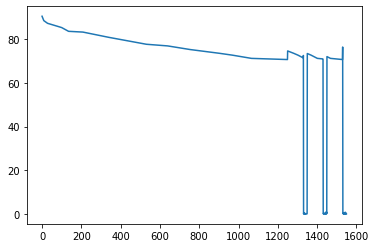

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

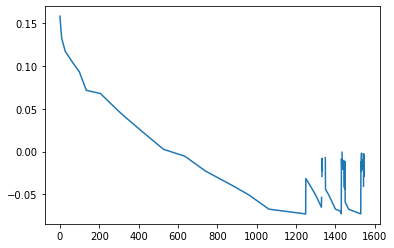

In [11]:
import numpy as np
c0 = 88.1552  # Value for C0
K0 = -0.0026  # Value for K0
K1 = -0.0004  # Value for K1
a = 0.0000    # Value for a
b = 0.0102    # Value for b
c = 2.8734    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    90.500000    90.275910    90.051821    89.827731    89.603641   
351    90.275910    90.051821    89.827731    89.603641    89.379552   
352    90.051821    89.827731    89.603641    89.379552    89.155462   
353    89.827731    89.603641    89.379552    89.155462    88.931373   
354    89.603641    89.379552    89.155462    88.931373    88.707283   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    89.379552    89.155462    88.931373    88.707283    88.494958  ...   
351    89.155462    88.931373    88.707283    88.494958    88.427731  ...   
352    88.931373    88.707283    88.494958    88.427731    88.360504  ...   
353    88.707283    88.494958    88.427731    88.360504    88.293277  ...   
354    88.494958    88.427731    88.360504    88.293277    88.226050  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   79.071008    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1100, 1, 251) (1100, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(88.1552, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0026, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0004, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0102, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.8734, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
14/14 [==============================] - 2s 40ms/step - loss: 5555.3462 - val_loss: 4427.3379
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 5457.9873 - val_loss: 4381.1016
Epoch 3/500
14/14 [==============================] - 0s 5ms/step - loss: 5397.6206 - val_loss: 4327.4248
Epoch 4/500
14/14 [==============================] - 0s 5ms/step - loss: 5340.4585 - val_loss: 4279.8862
Epoch 5/500
14/14 [==============================] - 0s 5ms/step - loss: 5285.1123 - val_loss: 4232.8804
Epoch 6/500
14/14 [==============================] - 0s 4ms/step - loss: 5230.3633 - val_loss: 4186.4175
Epoch 7/500
14/14 [==============================] - 0s 5ms/step - loss: 5176.1846 - val_loss: 4140.4556
Epoch 8/500
14/14 [==============================] - 0s 7ms/step - loss: 5122.5317 - val_loss: 4094.9634
Epoch 9/500
14/14 [==============================] - 0s 5ms/step - loss: 5069.3691 - val_loss: 4049.9155
Epoch 10/500
14/14 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 413ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[71.07381886, 71.06485528, 71.05589169, 71.0469281 , 71.03796452,
        71.02900093, 71.02003735, 71.01107376, 71.00211018, 70.99314659,
        70.98418301, 70.97521942, 70.96625584, 70.95729225, 70.94832866,
        70.93936508, 70.93040149, 70.92143791, 70.91247432, 70.90351074,
        70.89488796, 70.88648459, 70.87808123, 70.86967787, 70.86127451,
        70.85287115, 70.84446779, 70.83606443, 70.82766106, 70.8192577 ,
        70.81085434, 70.80245098, 70.79404762, 70.78564426, 70.7772409 ,
        70.76883754, 70.76043417, 70.75203081, 70.74362745, 70.73522409,
        70.72682073, 70.71841737, 70.71001401, 70.70161064, 70.69320728,
        70.68480392, 70.67640056, 74.5459384 , 74.445098  , 74.3442577 ,
        74.2434174 , 74.1377918 , 74.0285481 , 73.9193044 , 73.8100607 ,
        73.700817  , 73.5915733 , 73.4823296 , 73.3730859 , 73.2638422 ,
        73.1545985 , 73.0453548 , 72.9361111 , 72.8054902 , 72.6643137 ,
        72.5231373 , 72.3819608 , 72.2407843 , 72.0

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([68.02210551, 68.01743697, 68.01276844, 68.00809991, 68.00343137,
       67.99876284, 67.9940943 , 67.98942577, 67.98475724, 67.9800887 ,
       67.97542017, 67.97075163, 67.9660831 , 67.96141457, 67.95674603,
       67.9520775 , 67.94740896, 67.94274043, 67.9380719 , 67.93340336,
       67.92873483, 67.92406629, 67.91939776, 67.91472923, 67.91006069,
       67.90539216, 67.90072362, 67.89605509, 67.89138655, 67.88671802,
       67.88204949, 67.87738095, 67.87271242, 67.86804388, 67.86337535,
       67.85870682, 67.85403828, 67.84936975, 67.84470121, 67.84003268,
       67.83536415, 67.83069561, 67.82602708, 67.82135854, 67.81669001,
       67.81202148, 67.80735294, 67.80268441, 67.79603175, 67.78669468,
       67.77735761, 67.76802054, 67.75868347, 67.74934641, 67.74000934,
       67.73067227, 67.7213352 , 67.71199813, 67.70266106, 67.693324  ,
       67.68398693, 67.67464986, 67.66531279, 67.65597572, 67.64663866,
       67.63730159, 67.62796452, 67.61862745, 67.60929038, 67.59

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

33.837424106498574
19.711262452373713
